In [53]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import lightgbm as lgb
import joblib
import itertools
import numpy as np

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")


In [32]:
file_location = "/Users/alyssonamaral/Documents/ifood-case/case_data/df_modelo.csv"
df = pd.read_csv(file_location)

In [33]:
df_modelo = df[df['last_event'] == 'offer received']
df_modelo.head()


,last_event,account_id,amount,offer_id,target,age,credit_card_limit,registered_on,discount_value,duration,min_value,channel_web,channel_email,channel_mobile,channel_social,offer_bogo,offer_informational,offer_discount,gender_numeric
0,offer received,00bc983061d3471e8c8e74d31b7c8b6f,21.40,2906b810c7d4411798c6938adc9daaa5,0,59,77000.0,20171016,2,7.0,10,1,1,1,0,0,0,1,2
1,offer received,016871ea865d4338975026ae08d221d0,19.04,fafdcd668e3743c1bb461111dcafc2a4,0,57,79000.0,20180601,2,10.0,10,1,1,1,1,0,0,1,1
2,offer received,034dcdec0a0547a19d77dcf2bc8ecc48,11.37,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,57,76000.0,20171001,5,7.0,5,1,1,1,0,1,0,0,1
3,offer received,03e866224ec641c58bc93a69be00de9c,4.23,2906b810c7d4411798c6938adc9daaa5,0,80,47000.0,20180211,2,7.0,10,1,1,1,0,0,0,1,1
4,offer received,05ea8d8a95eb4b209a6e048878470df1,36.23,ae264e3637204a6fb9bb56bc8210ddfd,0,62,111000.0,20151103,10,7.0,10,0,1,1,1,1,0,0,1


In [34]:
variaveis = [
    'amount',
    'age',
    'credit_card_limit',
    'discount_value',
    'min_value',
    'channel_email',
    'channel_web',
    'channel_mobile',
    'channel_social',
    'offer_bogo',
    'offer_discount',
    'offer_informational',
    'gender_numeric'
]

variaveis_scaler = [
    'age',
    'credit_card_limit',
    'discount_value'
]

In [35]:
# Dataframe para valição e treino/teste
df_TnT, df_val  = train_test_split(df_modelo, test_size=0.05, random_state=42)

In [36]:
#Atribuição das variáveis escalares
scaler = StandardScaler()
df_TnT[variaveis_scaler] = scaler.fit_transform(df_TnT[variaveis_scaler])
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [37]:
df_val[variaveis_scaler] = scaler.transform(df_val[variaveis_scaler])

In [38]:
def model_lgbm(mod, df):
    """
    Função para treinar e avaliar um modelo de regressão utilizando LightGBM.
    """
    X = df.drop('amount', axis=1)
    y = df['amount'].values.astype('float')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    # Criar pipeline com scaler e modelo
    scaler = StandardScaler()
    mod_pipe = make_pipeline(scaler, mod)
    
    # Treinar o modelo
    mod_pipe.fit(X_train, y_train)
    
    # Predições
    y_pred_train = mod_pipe.predict(X_train)
    y_pred_test = mod_pipe.predict(X_test)
    
    # Avaliação do modelo
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"Treino - MAE: {train_mae:.4f}, MSE: {train_mse:.4f}, R²: {train_r2:.4f}")
    print(f"Teste - MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, R²: {test_r2:.4f}")
    
    # Visualização
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Gráfico de valores reais vs. previstos (teste)
    axs[0].scatter(y_test, y_pred_test, alpha=0.6)
    axs[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', ls='--')
    axs[0].set_title('Valores Reais vs. Previstos')
    axs[0].set_xlabel('Valores Reais')
    axs[0].set_ylabel('Valores Previstos')
    
    # Resíduos
    residuals = y_test - y_pred_test
    axs[1].scatter(y_pred_test, residuals, alpha=0.6)
    axs[1].axhline(y=0, color='red', ls='--')
    axs[1].set_title('Resíduos vs. Valores Previstos')
    axs[1].set_xlabel('Valores Previstos')
    axs[1].set_ylabel('Resíduos')
    
    plt.tight_layout()
    plt.show()
    
    return mod_pipe

In [39]:
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 192
[LightGBM] [Info] Number of data points in the train set: 683, number of used features: 11
[LightGBM] [Info] Start training from score 14.080000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

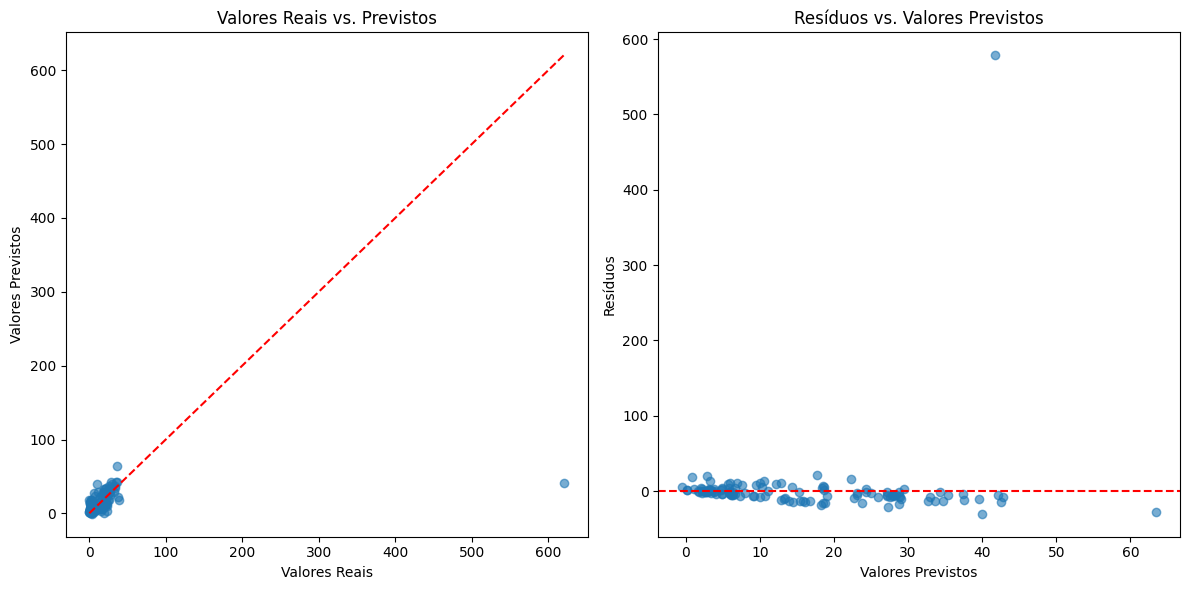

['mod_pipe.joblib']

In [25]:
mod_pipe = model_lgbm(model, df_TnT[variaveis])

joblib.dump(mod_pipe, 'mod_pipe.joblib')

### Teste do modelo em formato produtivo

In [54]:
# Gerar todas as combinações possíveis para os valores de canais e ofertas
combinacoes = list(itertools.product(
    [0, 1],  
    repeat=7  # 7 variáveis: 4 canais + 3 ofertas
))

variaveis_alvo = [
    'channel_email',
    'channel_web',
    'channel_mobile',
    'channel_social',
    'offer_bogo',
    'offer_discount',
    'offer_informational'
]

df_resultados = []

# Iterar sobre cada cliente no conjunto de validação

for _, cliente in df_val[variaveis].iterrows():
    melhor_predicao = -np.inf
    melhor_combinacao = None
    # Criar cópia do registro original
    cliente_original = cliente.copy()
    
    # Testar todas as combinações
    for combinacao in combinacoes:
        # Atualizar os valores de canais e ofertas
        cliente_testado = cliente_original.copy()
        cliente_testado[variaveis_alvo] = combinacao
        
        # Fazer a previsão usando o modelo
        predicao = mod_pipe.predict(cliente_testado.drop('amount').values.reshape(1, -1))[0]
        
        # Verificar se é a melhor previsão
        if predicao > melhor_predicao:
            melhor_predicao = predicao
            melhor_combinacao = combinacao
    
    # Salvar a melhor combinação e valor previsto
    cliente_resultado = cliente_original.copy()
    cliente_resultado['amount_predito'] = melhor_predicao
    for var, valor in zip(variaveis_alvo, melhor_combinacao):
        cliente_resultado[var] = valor
    
    df_resultados.append(cliente_resultado)

# Criar um DataFrame final com os resultados
df_resultados = pd.DataFrame(df_resultados)

# Calcular o ARPU real
arpu_real = df_val['amount'].mean()

# Calcular o ARPU predito com as melhores combinações
arpu_predito = df_resultados['amount_predito'].mean()

# Exibir os resultados
print(f"ARPU real: {arpu_real:.2f}")
print(f"ARPU predito com otimização: {arpu_predito:.2f}")
print(f"Aumento percentual no ARPU: {((arpu_predito - arpu_real) / arpu_real) * 100:.2f}%")

ARPU real: 15.72
ARPU predito com otimização: 30.00
Aumento percentual no ARPU: 90.86%
